<a href="https://colab.research.google.com/github/BD157/MLE-Capstone-BD/blob/main/Step_8_Method_3_Ray_Parallel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Reinstall correct versions
!pip uninstall -y numpy pandas scipy gensim umap-learn thinc spacy
!pip install -q numpy==1.26.4 pandas==2.2.2 scipy==1.11.4
!pip install -q gensim==4.3.2 umap-learn==0.5.5

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
Found existing installation: scipy 1.11.4
Uninstalling scipy-1.11.4:
  Successfully uninstalled scipy-1.11.4
Found existing installation: gensim 4.3.2
Uninstalling gensim-4.3.2:
  Successfully uninstalled gensim-4.3.2
Found existing installation: umap-learn 0.5.5
Uninstalling umap-learn-0.5.5:
  Successfully uninstalled umap-learn-0.5.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.19 requires spacy<4, which is not installed.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.11.4 which is incompatible.


In [ ]:
import gensim
import umap
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
# Mound Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
# Path where files are stored on the Google Drive
drive_folder = "/content/drive/My Drive/Sequence Data/"

# List files in the folder and verify file names
for file in os.listdir(drive_folder):
    print(file)

['Second3m_2022_sequences.acc', 'Second3m_2022_sequences.csv', 'Second3m_2022_sequences.fasta', 'merged_df.pkl', 'merged_df_large.csv', 'merged_df_sampled.csv', 'merged_df_100.csv', 'merged_df_1000.csv', 'merged_df_10000.csv', 'FastText_sars_cov2.model2.wv.vectors_ngrams.npy', 'FastText_sars_cov2.model2', 'embeddings_10k.npy', 'embeddings_PP_10k.npy']


In [ ]:
# Read the CSV file
merged_df_scale = pd.read_csv('/content/drive/MyDrive/Sequence Data/merged_df_10000_withpango.csv')

In [ ]:
print("\nColumns in merged DataFrame:", merged_df_scale.columns)
print("\nShape of merged DataFrame:", merged_df_scale.shape)
print("\nMissing values per column:\n", merged_df_scale.isnull().sum())


Columns in merged DataFrame: Index(['accession_id', 'organism_name', 'assembly', 'sra_accession',
       'organization', 'org_location', 'release_date', 'pangolin',
       'pangoversions', 'surveillance_sampling', 'isolate', 'species', 'genus',
       'family', 'molecule_type', 'length', 'nuc_completeness', 'genotype',
       'segment', 'geo_location', 'country', 'usa', 'host',
       'tissue_specimen_source', 'collection_date', 'genbank_title',
       'fasta_sequence', 'sequence_length', 'year', 'Year', 'Month'],
      dtype='object')

Shape of merged DataFrame: (10000, 31)

Missing values per column:
 accession_id                  0
organism_name                 0
assembly                  10000
sra_accession              3482
organization                  0
org_location                413
release_date                  0
pangolin                      0
pangoversions                 0
surveillance_sampling      3598
isolate                    2499
species                       0
genu

In [ ]:
def load_fasta_sequences_from_df(merged_df_scale, min_length=29000):
    sequences = []
    accession_ids = []

    for index, row in merged_df_scale.iterrows():
        seq = str(row['fasta_sequence']).upper()
        if len(seq) >= min_length:  # Only keep high-quality sequences
            sequences.append(seq)
            accession_ids.append(row['accession_id'])

    return sequences, accession_ids

sequences, accession_ids = load_fasta_sequences_from_df(merged_df_scale)

# Check results
print(f"Loaded {len(sequences)} sequences from merged dataset.")

Loaded 10000 sequences from merged dataset.


In [ ]:
from gensim.models import FastText

# Load Pre-trained FastText Model
model_path = "/content/drive/MyDrive/Sequence Data/FastText_sars_cov2.model2"
model = FastText.load(model_path)

# Check if file exists
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found at: {model_path}")

# Check if the model was loaded correctly
try:
    model = FastText.load(model_path)
    print("Model loaded successfully.")

except Exception as e:
    print(f"Failed to load model: {e}")

Model loaded successfully.


Method 3: Distributed Inference using Ray
Parallelize embedding generation across multiple CPU cores. First install and initialize Ray with a limited number of CPUs e.g., 2, to manage memory in low-resource environments like Colab. The generate_kmers function creates overlapping k-mers from sequences, and the embed_batch_with_ray function—decorated with @ray.remote loads a FastText model and computes embeddings for a batch of k-mer lists. Each batch runs as a distributed Ray task, enabling faster and scalable processing of large genomic datasets.


In [ ]:
# Method 3: Distributed Inference using Ray
!pip install -q ray
import ray

In [ ]:
# Define k-mer generator function
def generate_kmers(sequence, k=6):
    return [sequence[i:i + k] for i in range(len(sequence) - k + 1)]

In [ ]:
# Shut down any existing Ray cluster
ray.shutdown()

# Start Ray with limited CPU to prevent memory overload
ray.init(num_cpus=2)  # Use 1 or 2 CPUs if you're in Colab


2025-05-24 19:29:35,187	INFO worker.py:1888 -- Started a local Ray instance.


Python version:,3.11.12
Ray version:,2.46.0


In [ ]:
# Remote function to embed a batch of kmer lists
@ray.remote
def embed_batch_with_ray(kmers_batch, model_path="FastText_sars_cov2.model2"):

    model = FastText.load(model_path)
    embeddings2 = []

    for kmers in kmers_batch:
        vectors = [model.wv[k] for k in kmers if k in model.wv]
        embedding = np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)
        embeddings2.append(embedding)

    return embeddings2

Define a generator function generate_kmer_batches that splits sequences into batches, converts each sequence into k-mers, and yields them for processing. After running distributed embedding with Ray, it stacks all batch results into a single array of embeddings and saves them to disk as embeddings_ray_10k.npy. The final shape of the embeddings is printed to confirm successful processing.


In [ ]:
# Prepare batches of kmer sequences
def generate_kmer_batches(sequences, k=6, batch_size=200):
    for i in range(0, len(sequences), batch_size):
        batch = sequences[i:i + batch_size]
        kmers_batch = [generate_kmers(seq, k) for seq in batch]
        yield kmers_batch

In [ ]:
# Generate kmer batches and process with Ray
k = 6
batch_size = 200

futures = []
for kmers_batch in generate_kmer_batches(sequences, k=k, batch_size=batch_size):
    futures.append(embed_batch_with_ray.remote(kmers_batch, model_path=model_path))

# Collect results once all tasks are submitted
batch_results = ray.get(futures)


In [ ]:
# Merge all results into one embedding array
embeddings = np.vstack([np.vstack(batch) for batch in batch_results])

In [ ]:
# Save to disk
np.save("embeddings_ray_10k.npy", embeddings)
print("Final embeddings shape:", embeddings.shape)

Final embeddings shape: (10000, 100)


Then visualize a subset of 3,000 sequence embeddings using UMAP for dimensionality reduction. It selects the first 3,000 embeddings from the dataset, reduces them to 2 dimensions with UMAP preserving their structure and similarity, and then plots the results as a scatter plot using Matplotlib. This helps in visually identifying patterns, clusters, or outliers in the sequence data.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


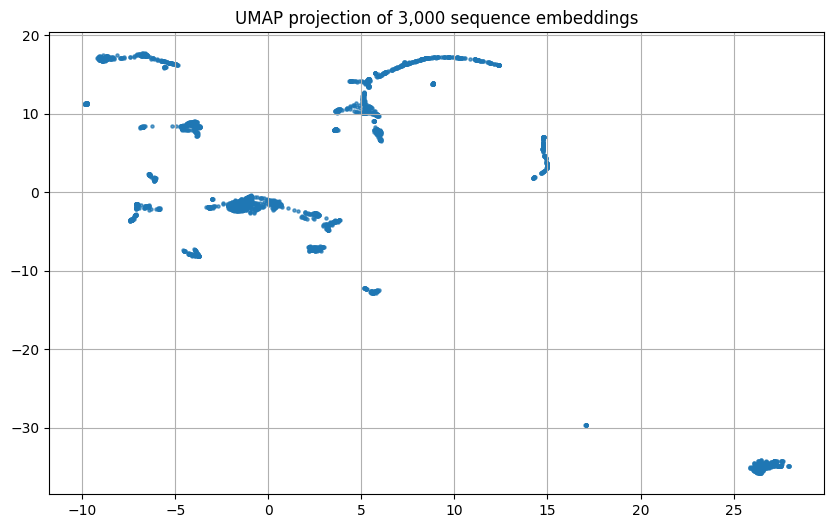

In [ ]:
import umap
import matplotlib.pyplot as plt

subset = embeddings[:3000]

reducer = umap.UMAP(n_components=2, random_state=42)
embedding_2d = reducer.fit_transform(subset)

plt.figure(figsize=(10, 6))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], s=5, alpha=0.7)
plt.title("UMAP projection of 3,000 sequence embeddings")
plt.grid(True)
plt.show()
